# Data Preprocessing
**Summary of Article**
- PV:
    - Description of raw dataset.
    - Missing values and imputation.
    - Normalized production profiles creation.
- Wind:
    - Description of raw dataset.
    - Missing Values and Imputation.
    - Normalized production profiles creation.
- Consumption:
    - Description of raw dataset.
    - Normalized production profiles creation.

The profiles are composed by consumption and production data. The data is real and anonymized, which will provided a more realistic representation of the behaviour of the systems in this study. The data is composed by:
- Consumption data: 69 time stamped data with the duration of one year.
- PV Production data: 10 time stamped data with the duration of one year.
- Wind Production data: 20 time stamped data with the duration of one year.


## Raw Data Exploration: PV Production Data
First, it is necessary to import the data and explore its structure.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# import utils from thesis_package in the parent directory.
import sys
sys.path.append('..')
from thesis_package import utils as ut

### PV: Raw Data Description
First the data is imported and briefly described.

In [2]:
# Get path to the parent folder.
# Import each data frame into a list.
def describe_data(data):
    print('Number of df: ', len(data))
    print('Head of df: \n', data[0].head())
    # Describre the dataframes.
    for i, df  in enumerate(data):
        print('File: ', i)
        print(df.describe())
        print('___________________________')
data_path = '..\data\\raw\profile\PV\IPMA (2 years 2020-2021)\\'
pv_data = ut.get_csv_from_folder(data_path)
describe_data(pv_data)

Number of df:  10
Head of df: 
                   date  value   T   R
0  2020-01-01 00:00:00    0.0 NaN NaN
1  2020-01-01 00:15:00    0.0 NaN NaN
2  2020-01-01 00:30:00    0.0 NaN NaN
3  2020-01-01 00:45:00    0.0 NaN NaN
4  2020-01-01 01:00:00    0.0 NaN NaN
File:  0
              value             T             R
count  70176.000000  70153.000000  70153.000000
mean     383.269572    288.969642    747.648987
std      559.559322      3.871006    739.292716
min        0.000000    275.930000      0.000000
25%        0.000000    286.407333     87.480646
50%        0.000000    288.729667    535.380093
75%      706.000000    291.471250   1217.935185
max     1909.000000    304.526000   2838.527778
___________________________
File:  1
              value             T             R
count  34238.000000  70153.000000  70153.000000
mean    1670.871838    290.069160    757.128517
std     2393.891953      5.158342    743.964051
min        0.000000    273.663000      0.000000
25%        0.000000   

In [3]:
# Turn the date column into datetime and set it as index.
def convert_to_timestamped_data(data):
    for i, df in enumerate(data):
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        data[i] = df
convert_to_timestamped_data(pv_data)

The full dataset is composed by a total of 10 time stamped data with the duration of one to two years. The the data is composed by the following features:
- Time: Time stamp of the data.
- PV Production: PV production power in kW.
- Predicted Temperature: Temperature in degrees K.
- Predicted Irradiance: Irradiance in W/m2.

### PV: Visualization
In order to better understand the data, it is necessary to visualize the features behavior.

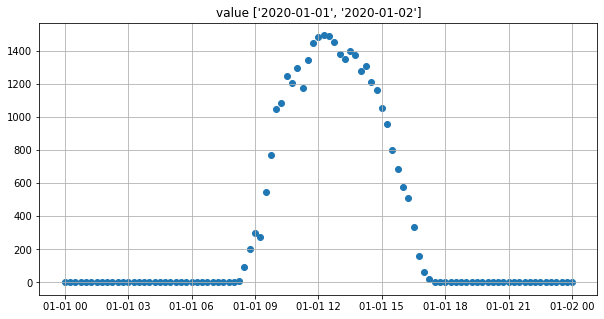

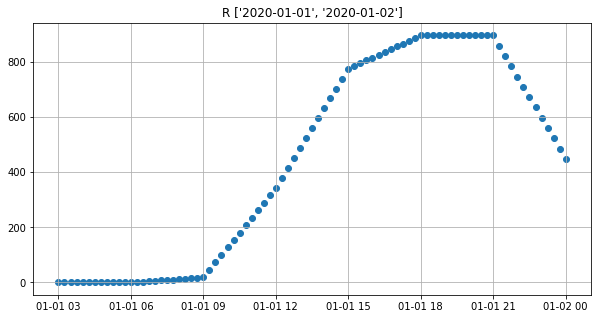

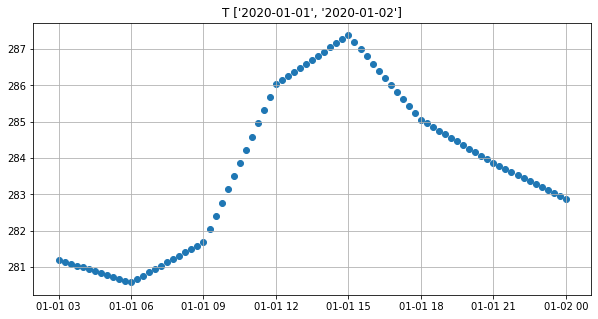

In [4]:
# Plot data from a specific data and time limits.
def plot_data_from_time_limits(target_data, feature, time_limits):
    _data = target_data[(target_data.index >= time_limits[0]) & (target_data.index <= time_limits[1]) ][[feature]]
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    ax.scatter(_data.index, _data[feature])
    ax.set_title('{} {}'.format(feature, time_limits))
    plt.grid()
    plt.show()
plot_data_from_time_limits(pv_data[0], 'value', ['2020-01-01', '2020-01-02'])
plot_data_from_time_limits(pv_data[0], 'R', ['2020-01-01', '2020-01-02'])
plot_data_from_time_limits(pv_data[0], 'T', ['2020-01-01', '2020-01-02'])

Regarding the features, it is posisble to observe the following:
- **Production value (value)**: The production value presents an expected shape. The the values are zero, both before the beguining of the mourning and after the end end of the afternoon, which correlates with the darker periods of the day. The maximum value is around mid-day, which correlates with the expected bright periods of the day.

- **Predicted Irradiance (R)**: The irradiance values are linear in periods of 3 hours, which indicates that the frequency of prediction is 3 hours, and the datapoints in between are linear interplations. The data is also inconsistent with the Production values, once the peak value is around sunset - night time, which indicate that the this feature needs to be processed in order to be useful for the prediction.

- **Predicted Temperature (T)**: The temperature values are linear in periods of 3 hours, which indicates that the frequency of prediction is 3 hours, and the datapoints in between are linear interplations. The data does not show inconsistency.

### PV: Analysing Missing Values
The data contains missing values. Since the production values are the focous for this study, it is necessary to deal with the missing values. In order to better understand the distribution of the missing values, the following questions will be answared:
- Number of missing values?
- Percentage of missing values overall?
- Percentage of missing values per year?
- Percentage of missing values per month?

In order to better understand the missing values, the following code will be used to add the columns with the year, month and hour of every data point.

In [5]:
def add_year_month_to_df(data):
    for df in data:
        df['year'] = df.index.year
        df['month'] =  df.index.month
add_year_month_to_df(pv_data)

In [6]:
# Get percentage of missing data per file per feature.
def get_percentage_of_per_feature(i, df):
    df_result = pd.DataFrame()
    for feature in df.columns:
        if feature != 'date' and feature != 'year' and feature != 'month':
            df_result.loc[i, feature] = 100 * df[feature].isnull().sum() / len(df)
    return df_result
def get_percentage_of_missing_data_per_file_per_feature(data):
    result = pd.DataFrame()
    for i, df in enumerate(data):
        result  = pd.concat([result, get_percentage_of_per_feature(i, df)], axis=0)
    return result
# Get percentage of missing data per file per year and/or month per feature.
def get_percentage_of_missing_values_per(data, time_frame=['year']):
    result = []
    for df in data:
        df_result = pd.DataFrame()
        for feature in df.columns:
                    if feature != 'date' and feature != 'year' and feature != 'month':
                        df_result[feature] = df.groupby(time_frame)[feature].apply(lambda x: 100 * x.isnull().sum() / len(x))
        result.append(df_result)
    return result

In [7]:
percentage_of_missing_data_per_file_per_feature = get_percentage_of_missing_data_per_file_per_feature(pv_data)
percentage_of_missing_values_per_year = get_percentage_of_missing_values_per(pv_data, time_frame=['year'])
percentage_of_missing_values_per_year_per_month = get_percentage_of_missing_values_per(pv_data, time_frame=['year', 'month'])

Analysing the percentage of missing data per file. we have that:

In [8]:
percentage_of_missing_data_per_file_per_feature

,value,T,R
0,0.000000,0.032775,0.032775
1,51.203592,0.017103,0.017103
2,22.116440,0.017103,0.017103
3,2.771603,0.032775,0.032775
4,2.771603,0.032775,0.032775
5,0.000000,0.032775,0.032775
6,0.000000,0.032775,0.032775
7,0.000000,0.032775,0.032775
8,1.335214,0.032775,0.032775
9,0.000000,0.032775,0.032775


From the `percentage_of_missing_data_per_file_per_feature` dataframe we can note that the file 1  and 2 contain around 50% and 20% of missing values, respectively. 

Analysing the percentage of missing data per file per year, we have that:

In [9]:
percentage_of_missing_values_per_year

[      value         T         R
 year                           
 2020    0.0  0.034153  0.034153
 2021    0.0  0.031393  0.031393,
            value         T         R
 year                                
 2020    2.555783  0.034153  0.034153
 2021  100.000000  0.000000  0.000000,
           value         T         R
 year                               
 2020   0.000000  0.034153  0.034153
 2021  44.300437  0.000000  0.000000,
          value         T         R
 year                              
 2020  5.535633  0.034153  0.034153
 2021  0.000000  0.031393  0.031393,
          value         T         R
 year                              
 2020  5.535633  0.034153  0.034153
 2021  0.000000  0.031393  0.031393,
       value         T         R
 year                           
 2020    0.0  0.034153  0.034153
 2021    0.0  0.031393  0.031393,
       value         T         R
 year                           
 2020    0.0  0.034153  0.034153
 2021    0.0  0.031393  0.031393,
       va

From the `percentage_of_missing_data_per_file_per_year_per_feature` dataframe we can note the year 2020 has a smaller percentage of missing values, so it is a good choice for obtaining preliminary results. So it is suitable for the cleaning process.

Now we can check the distribution of missing values per month, per year.

In [10]:
percentage_of_missing_values_per_year_per_month

[            value         T         R
 year month                           
 2020 1        0.0  0.403226  0.403226
      2        0.0  0.000000  0.000000
      3        0.0  0.000000  0.000000
      4        0.0  0.000000  0.000000
      5        0.0  0.000000  0.000000
      6        0.0  0.000000  0.000000
      7        0.0  0.000000  0.000000
      8        0.0  0.000000  0.000000
      9        0.0  0.000000  0.000000
      10       0.0  0.000000  0.000000
      11       0.0  0.000000  0.000000
      12       0.0  0.000000  0.000000
 2021 1        0.0  0.000000  0.000000
      2        0.0  0.000000  0.000000
      3        0.0  0.000000  0.000000
      4        0.0  0.000000  0.000000
      5        0.0  0.000000  0.000000
      6        0.0  0.000000  0.000000
      7        0.0  0.000000  0.000000
      8        0.0  0.000000  0.000000
      9        0.0  0.000000  0.000000
      10       0.0  0.000000  0.000000
      11       0.0  0.000000  0.000000
      12       0.0  0.369

From the `percentage_of_missing_data_per_file_per_year_per_month_per_feature` dataframe we can note that the month of february has a a null percentage of missing values, so it is a good choice for obtaining preliminary results.

## Raw Data Description: Wind Production Data

In [11]:
data_path = '..\data\\raw\profile\Wind\IPMA (2 years 2020-2021)\\'
wind_data = ut.get_csv_from_folder(data_path)
convert_to_timestamped_data(wind_data)
describe_data(wind_data)

Number of df:  20
Head of df: 
                      value   T   R  wind_speed  wind_direction
date                                                          
2020-01-01 00:00:00    0.0 NaN NaN         NaN             NaN
2020-01-01 00:15:00    0.0 NaN NaN         NaN             NaN
2020-01-01 00:30:00    0.0 NaN NaN         NaN             NaN
2020-01-01 00:45:00    0.0 NaN NaN         NaN             NaN
2020-01-01 01:00:00    0.0 NaN NaN         NaN             NaN
File:  0
              value             T             R    wind_speed  wind_direction
count  63524.000000  70153.000000  70153.000000  70153.000000    70153.000000
mean    3001.348932    289.893199    798.823422      7.403072      239.481862
std     2874.484190      3.707198    760.917081      3.207411      113.411583
min        0.000000    275.922000      0.000000      0.122154        0.058645
25%      520.000000    287.412000     98.727006      4.861206      127.899805
50%     2040.000000    289.783667    610.015278   

#### Wind: Raw Data Description
The full dataset is composed by a total of 20 time stamped data with the duration of one to two years. The the data is composed by the following features:
- Time: Time stamp of the data.
- Wind Production: Wind production power in kW.
- Predicetdd Temperature: Temperature in degrees K.
- Predicetdd Irradiance: Irradiance in W/m2.
- Predicetdd Wind Speed: Wind speed in m/s.
- Predicetdd Wind Direction: Wind direction in degrees.

#### Wind: Visualization
In order to better understand the data, it is necessary to visualize the features behavior.

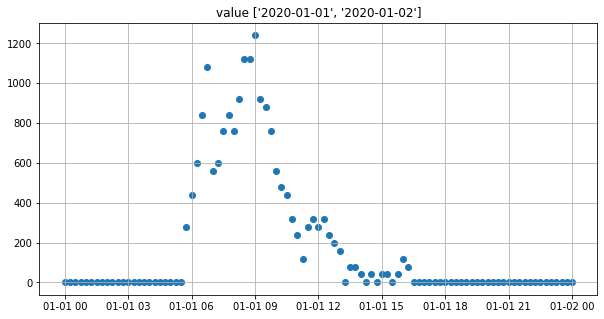

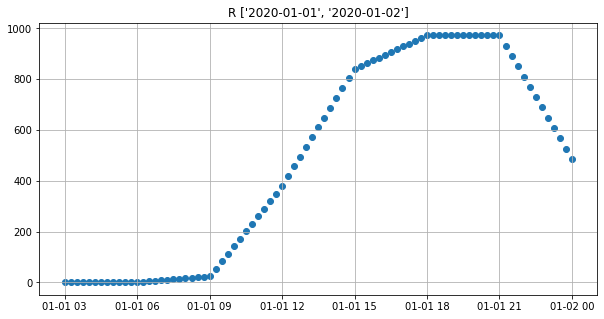

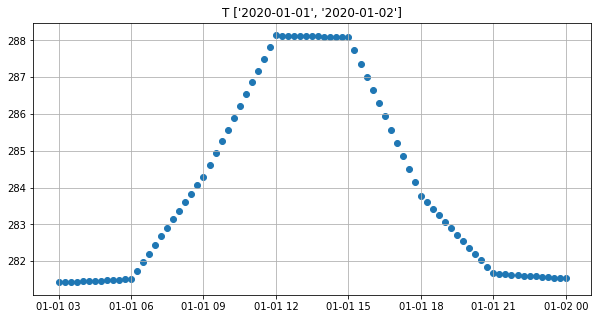

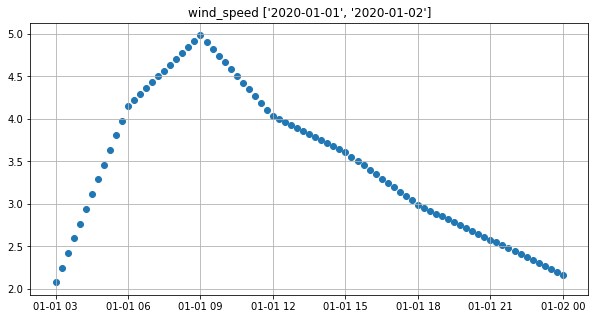

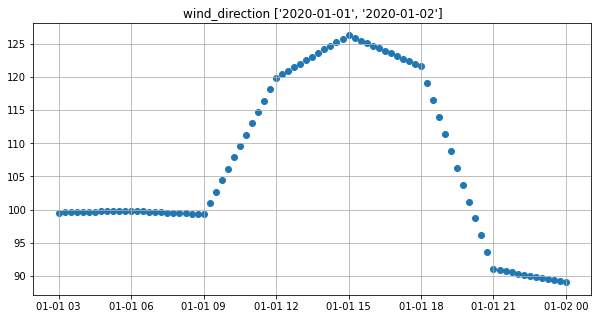

In [12]:
plot_data_from_time_limits(wind_data[0], 'value', ['2020-01-01', '2020-01-02'])
plot_data_from_time_limits(wind_data[0], 'R', ['2020-01-01', '2020-01-02'])
plot_data_from_time_limits(wind_data[0], 'T', ['2020-01-01', '2020-01-02'])
plot_data_from_time_limits(wind_data[0], 'wind_speed', ['2020-01-01', '2020-01-02'])
plot_data_from_time_limits(wind_data[0], 'wind_direction', ['2020-01-01', '2020-01-02'])

Regarding the features, it is posisble to observe the following:
- **Production value (value)**: The production values present some null values, which may be due to the fact that the wind turbine is turned off due to low demmand.

- **Predicted Irradiance (R)**: The irradiance values are linear in periods of 3 hours, which indicates that the frequency of prediction is 3 hours, and the datapoints in between are linear interpolations. The data is also inconsistent with reality, once the peak value is around sunset - night time, which indicate that the this feature needs to be processed in order to be useful for the prediction.

- **Predicted Temperature (T)**: The temperature values are linear in periods of 3 hours, which indicates that the frequency of prediction is 3 hours, and the datapoints in between are linear interpolations. The data does not show inconsistency.

- **Predicted Wind Speed (wind_speed)**: The wind speed values are linear in periods of 3 hours, which indicates that the frequency of prediction is 3 hours, and the datapoints in between are linear interpolations. The data does not show inconsistency.

- **Predicted Wind Direction (wind_direction)**: The wind direction values are linear in periods of 3 hours, which indicates that the frequency of prediction is 3 hours, and the datapoints in between are linear interpolations. The data does not show inconsistency.


#### Wind: Analysing Missing Values
The data contains missing values. Since the production values are the focous for this study, it is necessary to deal with the missing values. In order to better understand the distribution of the missing values, the following questions will be answared:
- Number of missing values?
- Percentage of missing values overall?
- Percentage of missing values per year?
- Percentage of missing values per month?

In [13]:
add_year_month_to_df(wind_data)
percentage_of_missing_data_per_file_per_feature = get_percentage_of_missing_data_per_file_per_feature(wind_data)
percentage_of_missing_values_per_year = get_percentage_of_missing_values_per(wind_data, time_frame=['year'])
percentage_of_missing_values_per_year_per_month = get_percentage_of_missing_values_per(wind_data, time_frame=['year', 'month'])

In [14]:
percentage_of_missing_data_per_file_per_feature

,value,T,R,wind_speed,wind_direction
0,9.479024,0.032775,0.032775,0.032775,0.032775
1,0.000000,0.032775,0.032775,0.032775,0.032775
2,0.000000,0.032775,0.032775,0.032775,0.032775
3,0.000000,0.032775,0.032775,0.032775,0.032775
4,5.159884,0.032775,0.032775,0.032775,0.032775
5,0.000000,0.032775,0.032775,0.032775,0.032775
6,0.000000,0.032775,0.032775,0.032775,0.032775
7,0.000000,0.032775,0.032775,0.032775,0.032775
8,0.000000,0.032775,0.032775,0.032775,0.032775
9,0.000000,0.032775,0.032775,0.032775,0.032775


From the `percentage_of_missing_data_per_file_per_feature` dataframe we can note that there is not any file with more than 15% of any feature missing.

In [15]:
percentage_of_missing_values_per_year_per_month

[                 value         T         R  wind_speed  wind_direction
 year month                                                            
 2020 1        0.000000  0.403226  0.403226    0.403226        0.403226
      2        0.000000  0.000000  0.000000    0.000000        0.000000
      3        0.000000  0.000000  0.000000    0.000000        0.000000
      4        0.000000  0.000000  0.000000    0.000000        0.000000
      5        0.000000  0.000000  0.000000    0.000000        0.000000
      6        0.000000  0.000000  0.000000    0.000000        0.000000
      7        0.000000  0.000000  0.000000    0.000000        0.000000
      8        0.000000  0.000000  0.000000    0.000000        0.000000
      9        0.000000  0.000000  0.000000    0.000000        0.000000
      10       0.000000  0.000000  0.000000    0.000000        0.000000
      11       0.000000  0.000000  0.000000    0.000000        0.000000
      12       0.000000  0.000000  0.000000    0.000000        0

From the output above, it is confirmed that indeed the month of february has a null percentage of missing values.

## Raw Data Description: Consumption Data

In [16]:
data_path = '..\data\\raw\profile\Conso\Clean Data\\'
conso_data = ut.get_csv_from_folder(data_path)
convert_to_timestamped_data(conso_data)
describe_data(conso_data)
add_year_month_to_df(conso_data)

Number of df:  64
Head of df: 
                         P    Q           T           R
date                                                  
2020-01-01 00:00:00  70.0  2.0  281.969500  405.454167
2020-01-01 00:15:00  72.0  2.0  281.924375  371.666319
2020-01-01 00:30:00  68.0  2.0  281.879250  337.878472
2020-01-01 00:45:00  70.0  6.0  281.834125  304.090625
2020-01-01 01:00:00  72.0  5.0  281.789000  270.302778
File:  0
                  P             Q             T             R
count  45569.000000  45569.000000  45569.000000  45569.000000
mean     122.579627     27.089359    287.147408    648.861610
std       53.927606     18.626930      5.445740    668.677534
min       22.000000     -3.000000    272.962000      0.000000
25%       79.000000     12.000000    283.646458     76.829062
50%      110.000000     22.000000    286.565833    447.426389
75%      158.000000     41.000000    290.329333   1001.572531
max      359.000000     98.000000    307.022000   2815.203704
________________

The full dataset is composed by a total of 69 time stamped data with the duration of one year. The the data is composed by the following features:
- Time: Time stamp of the data.
- Active Power Consumption: Consumption in kW.
- Reactive Power Consumption: Reactive power consumption in kVAr.
- Predicted Temperature: Temperature in degrees K.
- Predicted Irradiance: Irradiance in W/m2.

#### Conso: Visualization
In order to better understand the data, it is necessary to visualize the features behavior.

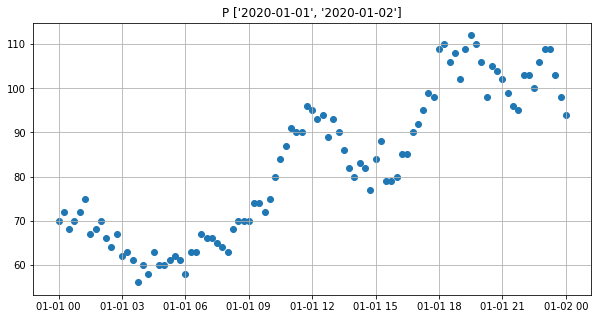

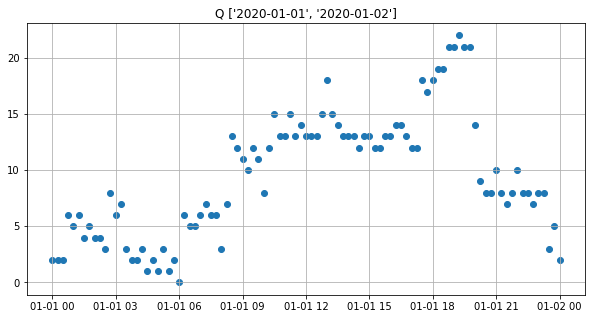

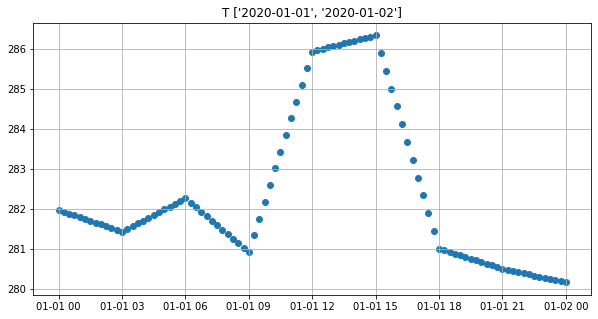

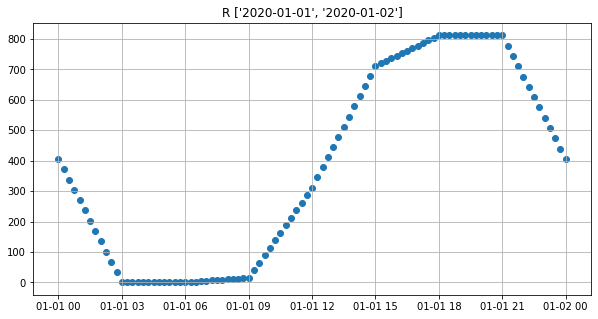

In [17]:
plot_data_from_time_limits(conso_data[0], 'P', ['2020-01-01', '2020-01-02'])
plot_data_from_time_limits(conso_data[0], 'Q', ['2020-01-01', '2020-01-02'])
plot_data_from_time_limits(conso_data[0], 'T', ['2020-01-01', '2020-01-02'])
plot_data_from_time_limits(conso_data[0], 'R', ['2020-01-01', '2020-01-02'])

Regarding the features, it is posisble to observe the following:
- **Active Power Consumption (P):** The active consumption power data depicts what would be expected of real datasets, with a measurements every 15 minutes. The data is consistent with reality, and the values are not too high.
- **Rective Power Consumption (P):** The reactive consumption power data depicts what would be expected of real datasets, with a measurements every 15 minutes. The data is consistent with reality, and the values are not too high. 
- **Predicted Temperature (T):** The temperature values are linear in periods of 3 hours, which indicates that the frequency of prediction is 3 hours, and the datapoints in between are linear interpolations. The data does not show inconsistency.
- **Predicted Irradiance (R):** The irradiance values are linear in periods of 3 hours, which indicates that the frequency of prediction is 3 hours, and the datapoints in between are linear interpolations. The data shows inconsistencies with reality, once the peak value is around sunset - night time, which indicate that the this feature needs to be processed in order to be useful for the prediction.

#### Consumption: Analysing Missing Values
The data contains missing values. Since the consumption values are the focous for this dataset, it is necessary to deal with the missing values. In order to better understand the distribution of the missing values, the following questions will be answared:
- Number of missing values?
- Percentage of missing values overall?
- Percentage of missing values per year?
- Percentage of missing values per month?

In [18]:
percentage_of_missing_data_per_file_per_feature = get_percentage_of_missing_data_per_file_per_feature(conso_data)

In [19]:
percentage_of_missing_data_per_file_per_feature

,P,Q,T,R
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
59,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0
61,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0


From the `percentage_of_missing_data_per_file_per_feature` dataframe we do not have any missing data.

The last date of each dataframe is:

In [20]:
for data in conso_data:
    print(data.index[-1])

2021-04-19 16:00:00
2021-04-19 11:00:00
2021-04-18 15:30:00
2021-03-29 08:15:00
2021-04-18 14:15:00
2021-04-18 16:45:00
2021-04-18 10:45:00
2021-04-19 12:45:00
2021-04-19 16:00:00
2021-04-18 09:00:00
2021-04-19 11:30:00
2021-04-18 12:30:00
2021-04-19 10:45:00
2021-04-18 14:45:00
2021-04-18 12:45:00
2021-04-18 11:30:00
2021-04-19 12:15:00
2021-04-18 15:00:00
2021-04-19 12:00:00
2021-04-18 10:30:00
2021-04-18 20:00:00
2021-04-18 13:00:00
2021-04-19 15:00:00
2021-04-18 10:00:00
2021-04-19 16:15:00
2021-04-19 15:30:00
2021-04-18 12:30:00
2021-04-18 09:30:00
2021-04-18 09:15:00
2021-04-19 15:30:00
2021-04-19 14:00:00
2021-04-19 16:15:00
2021-04-19 09:00:00
2021-04-19 12:45:00
2020-09-06 21:45:00
2021-04-18 12:45:00
2021-04-18 19:15:00
2021-04-19 16:15:00
2021-04-18 11:30:00
2021-04-18 16:00:00
2021-04-18 11:45:00
2021-04-18 08:00:00
2021-04-19 11:30:00
2021-04-18 14:30:00
2021-04-18 16:15:00
2021-04-18 14:45:00
2021-04-19 13:15:00
2021-04-19 17:15:00
2021-04-18 12:30:00
2021-04-18 10:00:00


## Data Pre-processing

### PV Data Pre-processing: Handling Missing Values
Since the file 0 does not contain any missing production values, it will be used as a reference to obtain the profile of the PV production for all productors. In terms of temperature T and irradiance I, some missing values are present, so we will use the mean value of the profile for each feature.

In [21]:
target_pv_data = pv_data[0]

In [22]:
percentage_of_missing_values_per_year_per_month = get_percentage_of_missing_values_per(pv_data, time_frame=['year', 'month'])[0]
percentage_of_missing_values_per_year_per_month

value         T         R
year month                           
2020 1        0.0  0.403226  0.403226
     2        0.0  0.000000  0.000000
     3        0.0  0.000000  0.000000
     4        0.0  0.000000  0.000000
     5        0.0  0.000000  0.000000
     6        0.0  0.000000  0.000000
     7        0.0  0.000000  0.000000
     8        0.0  0.000000  0.000000
     9        0.0  0.000000  0.000000
     10       0.0  0.000000  0.000000
     11       0.0  0.000000  0.000000
     12       0.0  0.000000  0.000000
2021 1        0.0  0.000000  0.000000
     2        0.0  0.000000  0.000000
     3        0.0  0.000000  0.000000
     4        0.0  0.000000  0.000000
     5        0.0  0.000000  0.000000
     6        0.0  0.000000  0.000000
     7        0.0  0.000000  0.000000
     8        0.0  0.000000  0.000000
     9        0.0  0.000000  0.000000
     10       0.0  0.000000  0.000000
     11       0.0  0.000000  0.000000
     12       0.0  0.369624  0.369624

There is some missing data in of January 2021 and December 2022, so we will plot these periods in order to better understand the behaviour of the data. 

In [23]:
# Plot data of January 2020 and December 2021.
def plot_missing_values_jan_dec(target_data, feature):
    _data_jan = target_data[(target_data.month == 1) & (target_data.year == 2020) ][[feature]]
    _data_dec = target_data[(target_data.month == 12) & (target_data.year == 2021) ][[feature]]
    fig, ax = plt.subplots(2,1, figsize=(20,10))
    # plot for January 2020.
    ax[0].plot(_data_jan[feature].fillna(0))
    ax[0].set_title('{} January 2020'.format(feature))
    # plot for December 2021.
    ax[1].plot(_data_dec[feature].fillna(0))
    ax[1].set_title('{} December 2021'.format(feature))
    plt.show()


#### PV Misisng Values: Temperature

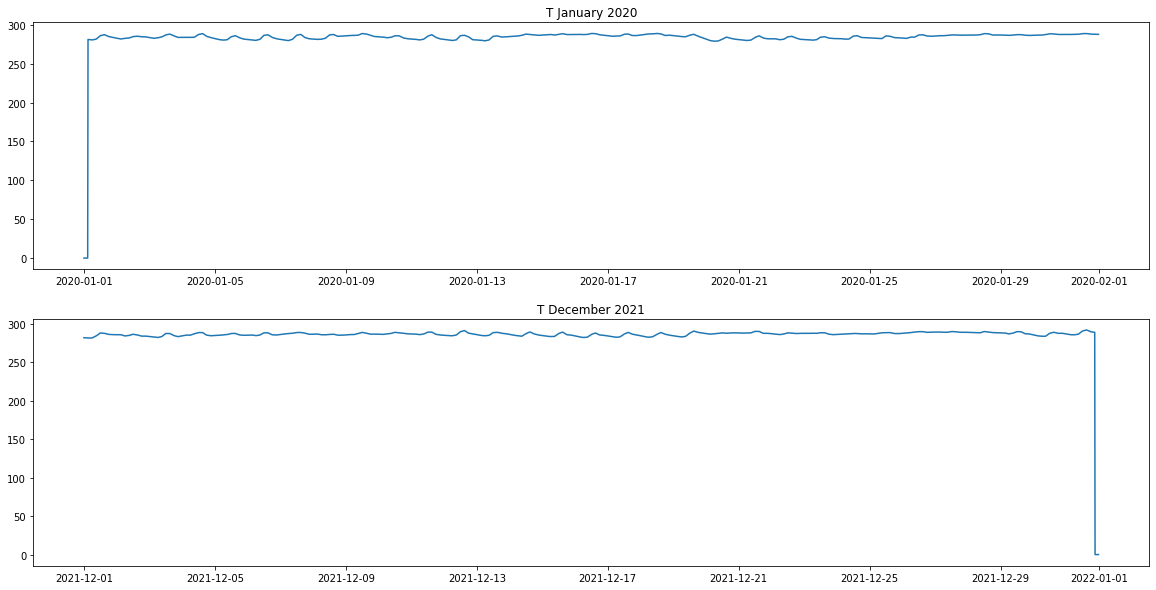

In [24]:
plot_missing_values_jan_dec(target_pv_data, 'T')

From the plots above the missing is concentrated in towoards the beguining and end of the months of January and December, respectivley. Therefore it is a good choice to check which part of days are missing, and input with the same period from another day.

In [25]:
target_pv_data[target_pv_data['T'].isnull() == True].index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:15:00',
               '2020-01-01 00:30:00', '2020-01-01 00:45:00',
               '2020-01-01 01:00:00', '2020-01-01 01:15:00',
               '2020-01-01 01:30:00', '2020-01-01 01:45:00',
               '2020-01-01 02:00:00', '2020-01-01 02:15:00',
               '2020-01-01 02:30:00', '2020-01-01 02:45:00',
               '2021-12-31 21:15:00', '2021-12-31 21:30:00',
               '2021-12-31 21:45:00', '2021-12-31 22:00:00',
               '2021-12-31 22:15:00', '2021-12-31 22:30:00',
               '2021-12-31 22:45:00', '2021-12-31 23:00:00',
               '2021-12-31 23:15:00', '2021-12-31 23:30:00',
               '2021-12-31 23:45:00'],
              dtype='datetime64[ns]', name='date', freq=None)

In order to check the behaviour of the temperature, similar periods of January and December are plotted.

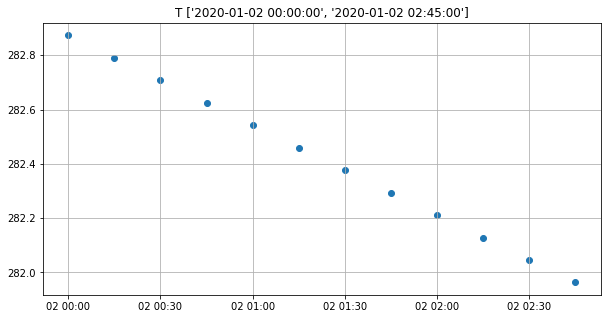

In [26]:
plot_data_from_time_limits(target_pv_data, 'T', ['2020-01-02 00:00:00',  '2020-01-02 02:45:00'])

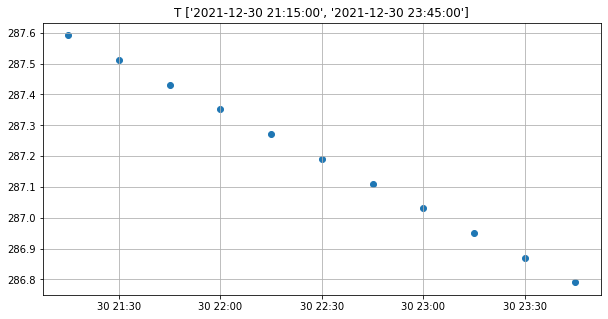

In [27]:
plot_data_from_time_limits(target_pv_data, 'T', ['2021-12-30 21:15:00',  '2021-12-30 23:45:00'])

Since, for this time frames, the data is appoximetelly linear we can use the same profile for the periods with missing data.

In [28]:
def get_index_of_time_frame(data, time_frame):
    return data[(target_pv_data.index >= time_frame[0]) & (target_pv_data.index <= time_frame[1])].index

In [29]:
# January 2020
target_index_jan = get_index_of_time_frame(target_pv_data, ['2020-01-01 00:00:00',  '2020-01-01 02:45:00'])
filler_index_jan = get_index_of_time_frame(target_pv_data, ['2020-01-02 00:00:00',  '2020-01-02 02:45:00'])
target_pv_data.loc[target_index_jan, 'T'] = target_pv_data.loc[filler_index_jan]['T'].values
# December 2021
target_index_dec = get_index_of_time_frame(target_pv_data, ['2021-12-31 21:15:00',  '2021-12-31 23:45:00'])
filler_index_dec = get_index_of_time_frame(target_pv_data, ['2021-12-30 21:15:00',  '2021-12-30 23:45:00'])
target_pv_data.loc[target_index_dec, 'T'] = target_pv_data.loc[filler_index_dec]['T'].values

In [30]:
target_pv_data[target_pv_data['T'].isnull() == True].index

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)

#### PV Missing Values: Irradiance

For the irradiance, the missing data is on the same periods as for the temperature data, so it is adequate to use the same approach as it was used for the temperature.

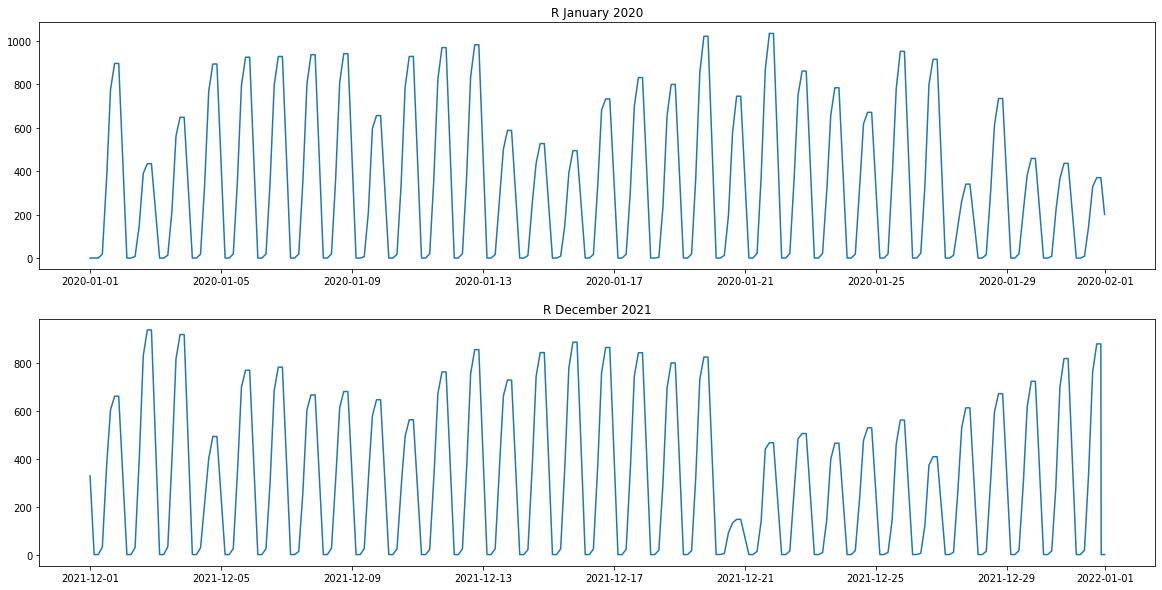

In [31]:
plot_missing_values_jan_dec(target_pv_data, 'R')

In [32]:
target_pv_data[target_pv_data['R'].isnull() == True].index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:15:00',
               '2020-01-01 00:30:00', '2020-01-01 00:45:00',
               '2020-01-01 01:00:00', '2020-01-01 01:15:00',
               '2020-01-01 01:30:00', '2020-01-01 01:45:00',
               '2020-01-01 02:00:00', '2020-01-01 02:15:00',
               '2020-01-01 02:30:00', '2020-01-01 02:45:00',
               '2021-12-31 21:15:00', '2021-12-31 21:30:00',
               '2021-12-31 21:45:00', '2021-12-31 22:00:00',
               '2021-12-31 22:15:00', '2021-12-31 22:30:00',
               '2021-12-31 22:45:00', '2021-12-31 23:00:00',
               '2021-12-31 23:15:00', '2021-12-31 23:30:00',
               '2021-12-31 23:45:00'],
              dtype='datetime64[ns]', name='date', freq=None)

In [33]:
# January 2020
target_index_jan = get_index_of_time_frame(target_pv_data, ['2020-01-01 00:00:00',  '2020-01-01 02:45:00'])
filler_index_jan = get_index_of_time_frame(target_pv_data, ['2020-01-02 00:00:00',  '2020-01-02 02:45:00'])
target_pv_data.loc[target_index_jan, 'R'] = target_pv_data.loc[filler_index_jan]['R'].values
# December 2021
target_index_dec = get_index_of_time_frame(target_pv_data, ['2021-12-31 21:15:00',  '2021-12-31 23:45:00'])
filler_index_dec = get_index_of_time_frame(target_pv_data, ['2021-12-30 21:15:00',  '2021-12-30 23:45:00'])
target_pv_data.loc[target_index_dec, 'R'] = target_pv_data.loc[filler_index_dec]['R'].values

### PV Data Pre-processing: Handling Inconsistent Values
The irradiance data is inconsistent with reality, once the peak value is around sunset - night time, which indicate that the this feature needs to be processed in order to be useful for the prediction. Therefore, to deal with this problem, every irradiantion data-point before sunrise and after sunset will be set to zero. In order to obtain the sunrise and sunset time for a given location, the [Astral](https://astral.readthedocs.io/en/latest/) library will be used. The location considered will be Beja, Portugal.

In [34]:
from astral import LocationInfo
from astral.sun import sun
import datetime
city = LocationInfo("Beja", "Portugal", "Europe/Lisbon", 38.0223347, -7.958667)
print((
    f"Information for {city.name}/{city.region}\n"
    f"Timezone: {city.timezone}\n"
    f"Latitude: {city.latitude:.02f}; Longitude: {city.longitude:.02f}\n"
))

Information for Beja/Portugal
Timezone: Europe/Lisbon
Latitude: 38.02; Longitude: -7.96



In order to clean inconsistent irradiance data, the function `clean_inconsistent_data()` will be used. The algorithm works as follows.
For each row os the data frame:
- If date of data-point not in present in hash-table, add it.
- If date of the data-point is outside the time window of sunrise until sunset, the data-point is set to zero.
- Else, the data-point is kept as is.

In [35]:
def clean_inconsistent_irradiance_data(data):
    _hash_table = {}
    clean_data = pd.DataFrame(index=data.index, columns=data.columns)
    for index, row in data.iterrows():
        if index.date() not in _hash_table.keys():
            _hash_table[index.date()] = {'sunrise': sun(city.observer, date=index.date())['sunrise'].time(),
                                         'sunset': sun(city.observer, date=index.date())['sunset'].time()}
        if index.time() <= _hash_table[index.date()]['sunrise'] or index.time() >= _hash_table[index.date()]['sunset']:
            row.R = 0
            clean_data.loc[index] = row
        else: 
            clean_data.loc[index] = row
    return clean_data
clean_pv_data = clean_inconsistent_irradiance_data(target_pv_data)

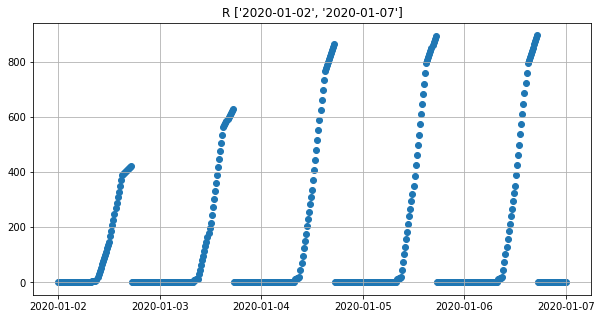

In [36]:
plot_data_from_time_limits(clean_pv_data, 'R', ['2020-01-02', '2020-01-07'])

### Wind: Data Proprocessing
Since the file 1 of the Wind productor does not contain any missing production values we can use it as a reference to obtain the profile of the Wind production for all productors. In terms of production value, it will be done by normalizing the profile, and then adding a small deviation of 20% to the production values for each productor, and then multiplying the profile by the given installed power. The profile will be normalized by the maximum value of the profile.

In terms of temperature T and irradiance I, some missing values are present, so we will use the mean value of the profile for each feature.

In [37]:
target_wind_data = wind_data[1]
percentage_of_missing_values_per_year_per_month = get_percentage_of_missing_values_per(wind_data, time_frame=['year', 'month'])[1]

In [38]:
percentage_of_missing_values_per_year_per_month

value         T         R  wind_speed  wind_direction
year month                                                       
2020 1        0.0  0.403226  0.403226    0.403226        0.403226
     2        0.0  0.000000  0.000000    0.000000        0.000000
     3        0.0  0.000000  0.000000    0.000000        0.000000
     4        0.0  0.000000  0.000000    0.000000        0.000000
     5        0.0  0.000000  0.000000    0.000000        0.000000
     6        0.0  0.000000  0.000000    0.000000        0.000000
     7        0.0  0.000000  0.000000    0.000000        0.000000
     8        0.0  0.000000  0.000000    0.000000        0.000000
     9        0.0  0.000000  0.000000    0.000000        0.000000
     10       0.0  0.000000  0.000000    0.000000        0.000000
     11       0.0  0.000000  0.000000    0.000000        0.000000
     12       0.0  0.000000  0.000000    0.000000        0.000000
2021 1        0.0  0.000000  0.000000    0.000000        0.000000
     2        0.0  0.000000  0.000000    0.000000        0.000000
     3        0.0  0.000000  0.000000    0.000000        0.000000
     4        0.0  0.000000  0.000000    0.000000        0.000000
     5        0.0  0.000000  0.000000    0.000000        0.000000
     6        0.0  0.000000  0.000000    0.000000        0.000000
     7        0.0  0.000000  0.000000    0.000000        0.000000
     8        0.0  0.000000  0.000000    0.000000        0.000000
     9        0.0  0.000000  0.000000    0.000000        0.000000
     10       0.0  0.000000  0.000000    0.000000        0.000000
     11       0.0  0.000000  0.000000    0.000000        0.000000
     12       0.0  0.369624  0.369624    0.369624        0.369624

#### Wind Missing Values: Temperature

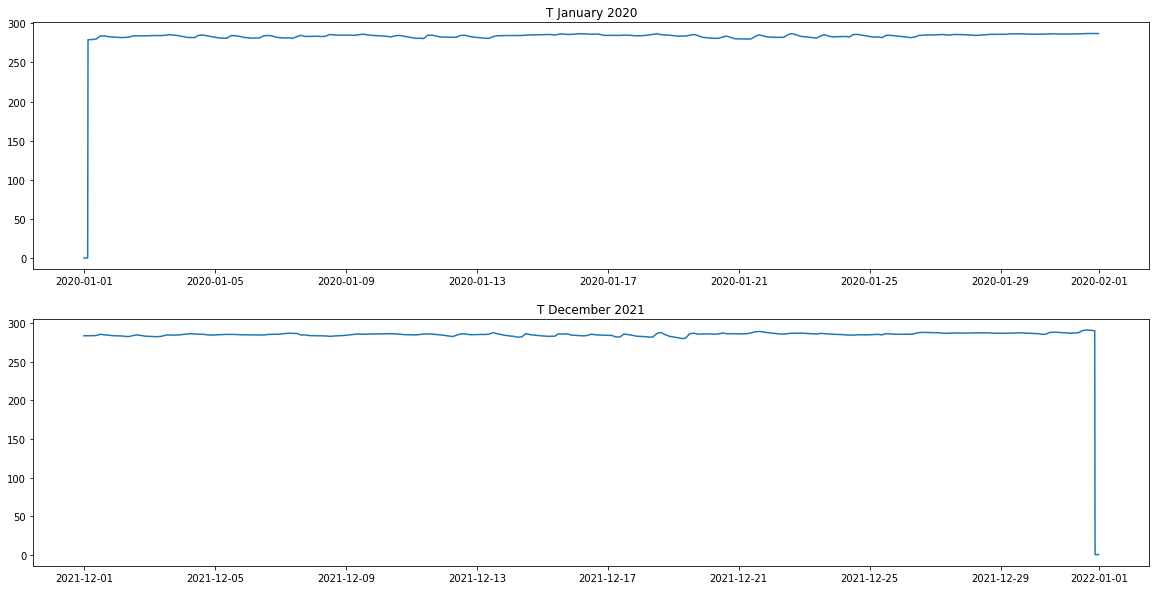

In [39]:
plot_missing_values_jan_dec(target_wind_data, 'T')

Since the situation is the same as for the PV data, the approach will be the same.

In [40]:
target_wind_data[target_wind_data['T'].isnull() == True].index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:15:00',
               '2020-01-01 00:30:00', '2020-01-01 00:45:00',
               '2020-01-01 01:00:00', '2020-01-01 01:15:00',
               '2020-01-01 01:30:00', '2020-01-01 01:45:00',
               '2020-01-01 02:00:00', '2020-01-01 02:15:00',
               '2020-01-01 02:30:00', '2020-01-01 02:45:00',
               '2021-12-31 21:15:00', '2021-12-31 21:30:00',
               '2021-12-31 21:45:00', '2021-12-31 22:00:00',
               '2021-12-31 22:15:00', '2021-12-31 22:30:00',
               '2021-12-31 22:45:00', '2021-12-31 23:00:00',
               '2021-12-31 23:15:00', '2021-12-31 23:30:00',
               '2021-12-31 23:45:00'],
              dtype='datetime64[ns]', name='date', freq=None)

#### Wind Missing Values: Irradiance

For the irradiance, the missing data is on the same periods as for the temperature data, so it is adequate to use the same approach as it was used for the temperature.

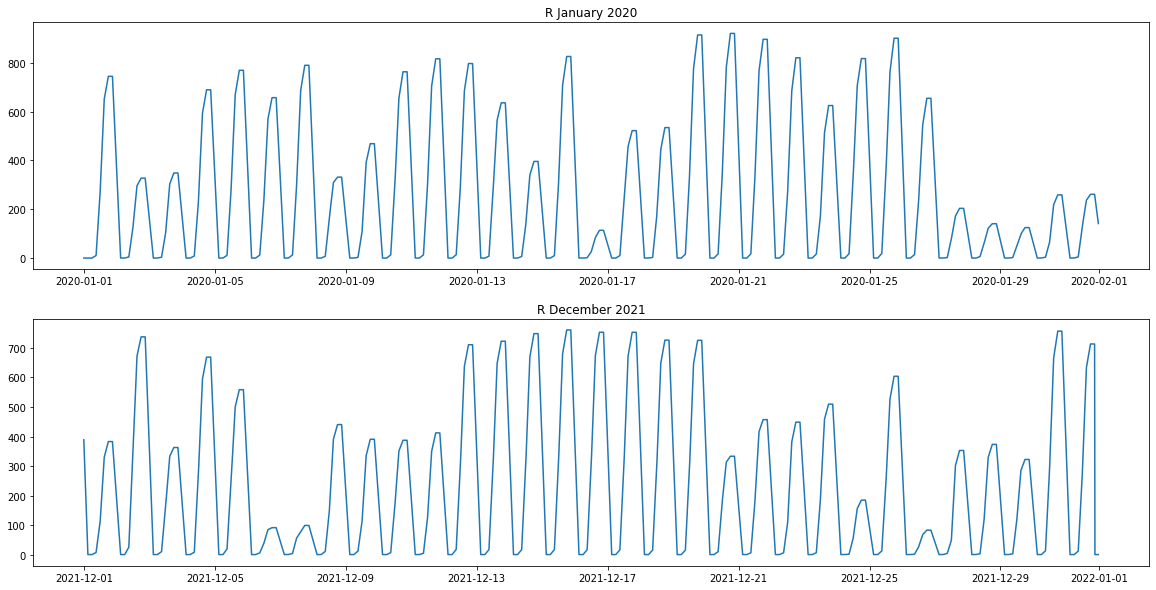

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:15:00',
               '2020-01-01 00:30:00', '2020-01-01 00:45:00',
               '2020-01-01 01:00:00', '2020-01-01 01:15:00',
               '2020-01-01 01:30:00', '2020-01-01 01:45:00',
               '2020-01-01 02:00:00', '2020-01-01 02:15:00',
               '2020-01-01 02:30:00', '2020-01-01 02:45:00',
               '2021-12-31 21:15:00', '2021-12-31 21:30:00',
               '2021-12-31 21:45:00', '2021-12-31 22:00:00',
               '2021-12-31 22:15:00', '2021-12-31 22:30:00',
               '2021-12-31 22:45:00', '2021-12-31 23:00:00',
               '2021-12-31 23:15:00', '2021-12-31 23:30:00',
               '2021-12-31 23:45:00'],
              dtype='datetime64[ns]', name='date', freq=None)

In [42]:
plot_missing_values_jan_dec(target_wind_data, 'R')
target_wind_data[target_wind_data['R'].isnull() == True].index

In [43]:
# January 2020
target_index_dec = get_index_of_time_frame(target_wind_data, ['2020-01-01 00:00:00',  '2020-01-01 02:45:00'])
filler_index_dec = get_index_of_time_frame(target_wind_data, ['2020-01-02 00:00:00',  '2020-01-02 02:45:00'])
target_wind_data.loc[target_index_dec, 'R'] = target_wind_data.loc[filler_index_dec]['R'].values
# December 2021
target_index_dec = get_index_of_time_frame(target_wind_data, ['2021-12-31 21:15:00',  '2021-12-31 23:45:00'])
filler_index_dec = get_index_of_time_frame(target_wind_data, ['2021-12-30 21:15:00',  '2021-12-30 23:45:00'])
target_wind_data.loc[target_index_dec, 'R'] = target_wind_data.loc[filler_index_dec]['R'].values

#### Wind Missing Values: Wind velocity

In order the understand the behaviour of the wind velocity, it is necessary to plot the wind velocity data.

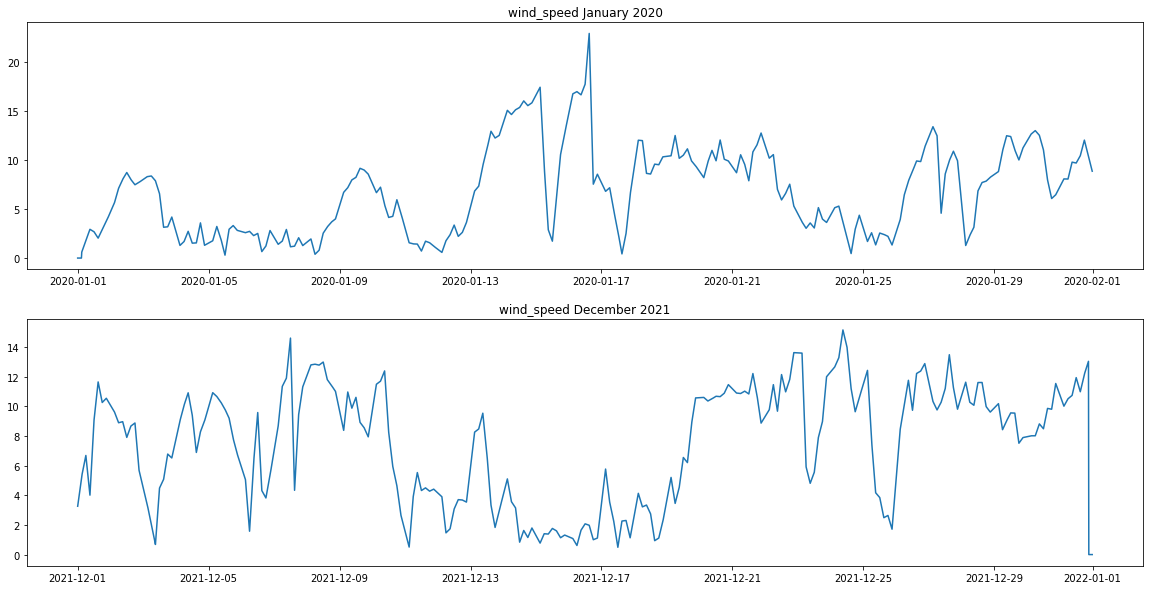

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:15:00',
               '2020-01-01 00:30:00', '2020-01-01 00:45:00',
               '2020-01-01 01:00:00', '2020-01-01 01:15:00',
               '2020-01-01 01:30:00', '2020-01-01 01:45:00',
               '2020-01-01 02:00:00', '2020-01-01 02:15:00',
               '2020-01-01 02:30:00', '2020-01-01 02:45:00',
               '2021-12-31 21:15:00', '2021-12-31 21:30:00',
               '2021-12-31 21:45:00', '2021-12-31 22:00:00',
               '2021-12-31 22:15:00', '2021-12-31 22:30:00',
               '2021-12-31 22:45:00', '2021-12-31 23:00:00',
               '2021-12-31 23:15:00', '2021-12-31 23:30:00',
               '2021-12-31 23:45:00'],
              dtype='datetime64[ns]', name='date', freq=None)

In [44]:
plot_missing_values_jan_dec(target_wind_data, 'wind_speed')
target_wind_data[target_wind_data['wind_speed'].isnull() == True].index

Since the wind velocity is bery volatile, the missing data will be set to the mean values of the wind velocity for the following hour.

In [45]:
# get mean value of a column for a given time frame.
def get_mean_value_from_index(data, feature, index):
    return data[feature].loc[index].mean()
data = target_wind_data
feature = 'wind_speed'
index = filler_index_jan

In [46]:
data[feature].loc[index].mean()

5.145081647457693

In [47]:
# January 2020
target_index_jan = get_index_of_time_frame(target_wind_data, ['2020-01-01 00:00:00',  '2020-01-01 02:45:00'])
filler_index_jan = get_index_of_time_frame(target_wind_data, ['2020-01-01 03:00:00', '2020-01-01 04:00:00' ])
mean_value_jan = get_mean_value_from_index(target_wind_data, 'wind_speed', filler_index_jan)
target_wind_data.loc[target_index_jan, 'wind_speed'] = mean_value_jan
# December 2021
target_index_dec = get_index_of_time_frame(target_wind_data, ['2021-12-31 21:15:00',  '2021-12-31 23:45:00'])
filler_index_dec = get_index_of_time_frame(target_wind_data, ['2021-12-31 20:00:00', '2021-12-31 21:00:00'])
mean_value_dec = get_mean_value_from_index(target_wind_data, 'wind_speed', filler_index_dec)


#### Wind Missing Values: Wind Direction

In order the understand the behaviour of the wind direction, it is necessary to plot the wind direction data.

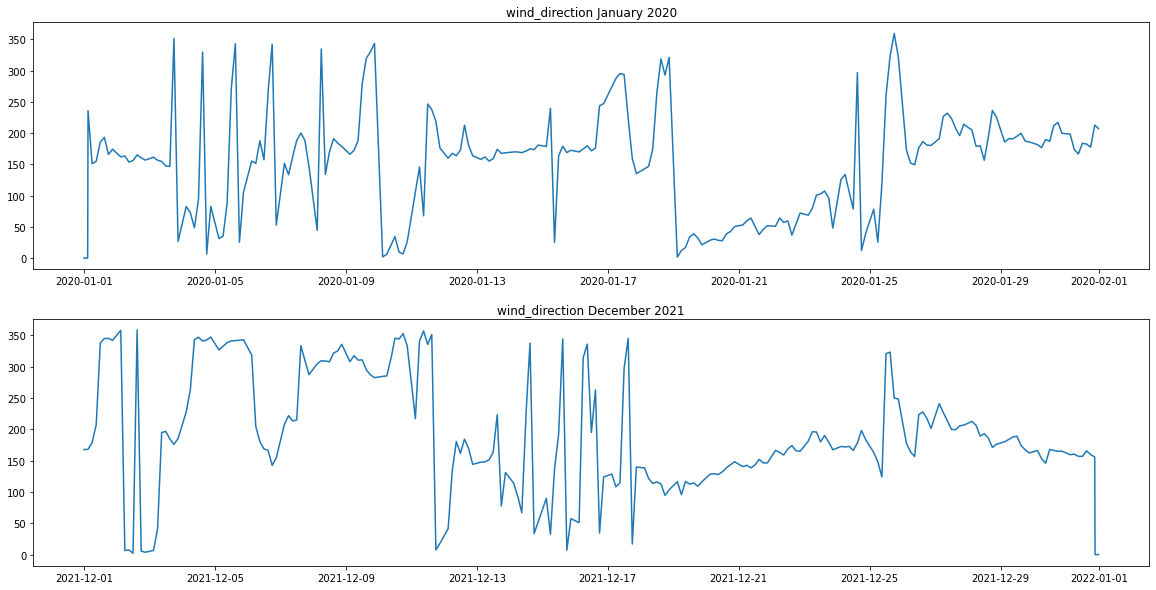

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:15:00',
               '2020-01-01 00:30:00', '2020-01-01 00:45:00',
               '2020-01-01 01:00:00', '2020-01-01 01:15:00',
               '2020-01-01 01:30:00', '2020-01-01 01:45:00',
               '2020-01-01 02:00:00', '2020-01-01 02:15:00',
               '2020-01-01 02:30:00', '2020-01-01 02:45:00',
               '2021-12-31 21:15:00', '2021-12-31 21:30:00',
               '2021-12-31 21:45:00', '2021-12-31 22:00:00',
               '2021-12-31 22:15:00', '2021-12-31 22:30:00',
               '2021-12-31 22:45:00', '2021-12-31 23:00:00',
               '2021-12-31 23:15:00', '2021-12-31 23:30:00',
               '2021-12-31 23:45:00'],
              dtype='datetime64[ns]', name='date', freq=None)

In [48]:
plot_missing_values_jan_dec(target_wind_data, 'wind_direction')
target_wind_data[target_wind_data['wind_direction'].isnull() == True].index

Once the wind direction is just as volatile as the wind velocity, the missing data will be set to the mean values of the wind direction for the following hour.

In [49]:
# January 2020
target_index_jan = get_index_of_time_frame(target_wind_data, ['2020-01-01 00:00:00',  '2020-01-01 02:45:00'])
filler_index_jan = get_index_of_time_frame(target_wind_data, ['2020-01-01 03:00:00', '2020-01-01 04:00:00' ])
mean_value_jan = get_mean_value_from_index(target_wind_data, 'wind_direction', filler_index_jan)
target_wind_data.loc[target_index_jan, 'wind_direction'] = mean_value_jan
# December 2021
target_index_dec = get_index_of_time_frame(target_wind_data, ['2021-12-31 21:15:00',  '2021-12-31 23:45:00'])
filler_index_dec = get_index_of_time_frame(target_wind_data, ['2021-12-31 20:00:00', '2021-12-31 21:00:00'])
mean_value_dec = get_mean_value_from_index(target_wind_data, 'wind_direction', filler_index_dec)
target_wind_data.loc[target_index_dec, 'wind_direction'] = mean_value_dec

## Normalize Profile Generation and Data Writting
Once the raw data is clean, now it is possoble to create the desired normalized profiles. The normalization is the division of the production or consumption value by the maximum value of the profile.

### Production Normalization

In [50]:
# Normalize value of a given dataframe column.
def create_normalized_column(data, feature):
    return data[feature] / data[feature].max()

Before normalization:


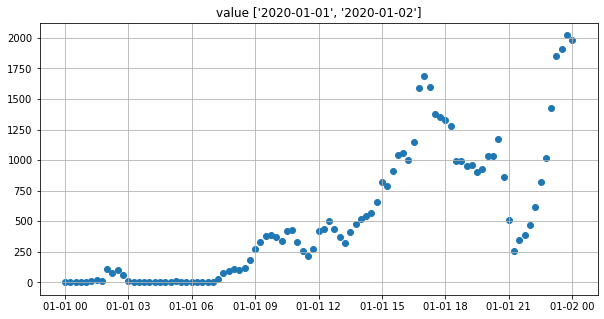

After normalization:


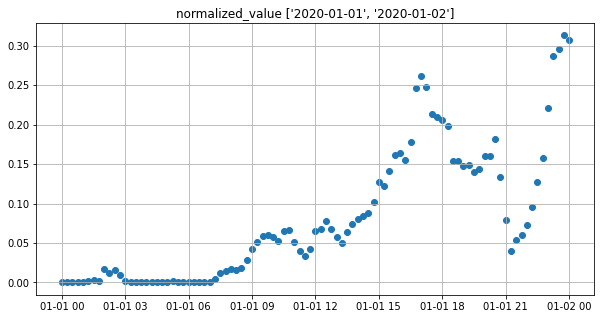

In [51]:
print('Before normalization:')
plot_data_from_time_limits(target_wind_data, 'value', ['2020-01-01', '2020-01-02'])
target_wind_data['normalized_value'] = create_normalized_column(target_wind_data, 'value')
print('After normalization:')
plot_data_from_time_limits(target_wind_data, 'normalized_value', ['2020-01-01', '2020-01-02'])

Before normalization:


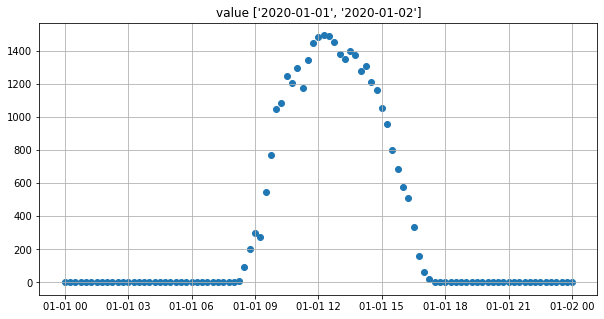

After normalization:


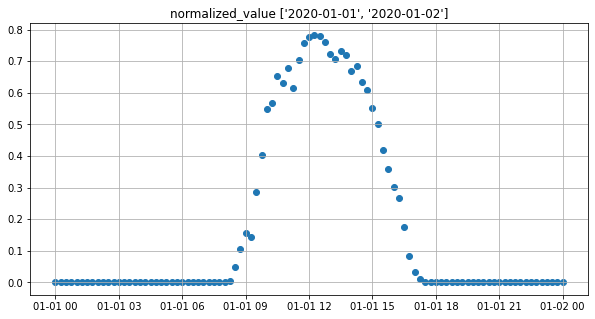

In [52]:
print('Before normalization:')
plot_data_from_time_limits(target_pv_data, 'value', ['2020-01-01', '2020-01-02'])
target_pv_data['normalized_value'] = create_normalized_column(target_pv_data, 'value')
print('After normalization:')
plot_data_from_time_limits(target_pv_data, 'normalized_value', ['2020-01-01', '2020-01-02'])

Since our consumption data only contains values until the 15th March of 2021, we will crop the production data to this period as well.

In [53]:
target_pv_data = target_pv_data[target_pv_data.index <= '2021-04-15 23:45:00']
target_wind_data = target_wind_data[target_wind_data.index <= '2021-04-15 23:45:00']

In [54]:
len(target_pv_data)

45216

In [55]:
def write_data_to_csv(data, file_name):
    # data.to_csv(file_name, index=False) Uncomment to write data
    pass

In [56]:
target_pv_data['date'] = target_pv_data.index
target_pv_data.reset_index(drop=True, inplace=True)
target_wind_data['date'] = target_wind_data.index
target_wind_data.reset_index(drop=True, inplace=True)

C:\Users\jamil\AppData\Local\Temp\ipykernel_15024\1246388182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_pv_data['date'] = target_pv_data.index
C:\Users\jamil\AppData\Local\Temp\ipykernel_15024\1246388182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_wind_data['date'] = target_wind_data.index


In [57]:
write_data_to_csv(target_wind_data, '../data/processed/production/wind_data_processed.csv')
write_data_to_csv(target_pv_data, '../data/processed/production/pv_data_processed.csv')

In [58]:
target_pv_data

,value,T,R,year,month,normalized_value,date
0,0.0,282.260500,448.421296,2020,1,0.0,2020-01-01 00:00:00
1,0.0,282.228792,411.052855,2020,1,0.0,2020-01-01 00:15:00
2,0.0,282.197083,373.684414,2020,1,0.0,2020-01-01 00:30:00
3,0.0,282.165375,336.315972,2020,1,0.0,2020-01-01 00:45:00
4,0.0,282.133667,298.947531,2020,1,0.0,2020-01-01 01:00:00
...,...,...,...,...,...,...,...
45211,0.0,287.452167,826.054398,2021,4,0.0,2021-04-15 22:45:00
45212,0.0,287.408333,777.462963,2021,4,0.0,2021-04-15 23:00:00
45213,0.0,287.364500,728.871528,2021,4,0.0,2021-04-15 23:15:00
45214,0.0,287.320667,680.280093,2021,4,0.0,2021-04-15 23:30:00


### Consumption Normalization

The same approach will be used to normalize the production and consumption profiles.

The size of the profiles are:

In [73]:
possible_files = [i for i, data in enumerate(conso_data) if data.index[-1].month > 3 and data.index[-1].year == 2021] 
file_length_array = [len(conso_data[i]) for i in possible_files]

In [75]:
# Find the most common integer in the array file_length_array.
most_common_file_length = max(set(file_length_array), key=file_length_array.count)


In [60]:
# Delete all the data after 2021-04-15 23:45:00 for every file of the conso_data.
for i in range(len(conso_data)):
    conso_data[i] = conso_data[i][conso_data[i].index <= '2021-04-15 23:45:00']
for i in possible_files:
    print(conso_data[i].index[-1])  

2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00
2021-04-15 23:45:00


In [77]:
for i in possible_files:
    conso_data[i]['normalized_P'] = create_normalized_column(conso_data[i], 'P')
    conso_data[i]['normalized_Q'] = create_normalized_column(conso_data[i], 'Q')
    conso_data[i]['date'] = conso_data[i].index
    if len(conso_data[i]) == most_common_file_length:
        # write csv file to ../data/processed/consumption folder.
        write_data_to_csv(conso_data[i], '../data/processed/consumption/conso_' + str(i) + '_processed.csv')